In [67]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import ticker
import pycountry_convert as pc  
from sklearn.metrics import mean_absolute_error, r2_score
from matplotlib import ticker
from scipy.stats import linregress

In [68]:
path = "/Users/laurenfeldman/COMP 562/ML-Climate-Project/raw-data/Extreme_weather_raw.csv"
df = pd.read_csv(path)


#### Top 5 countries with most positive linear relationship between extreme weather and temperature: 
1. USA
2. Russia
3. China
4. India
5. Mexico


In [69]:
def linear_coefs(X, Y):
  """
  Args:
    X: N x d matrix of input features
    Y: N x 1 matrix (column vector) of output response

  Returns:
    Beta: d x 1 matrix of linear coefficients
  """
  #Use Normal Equation (X^T*X)(beta) = (X^T * Y) to find linear coefficients
  x_tf = tf.constant(X, dtype=tf.float32)
  y_tf = tf.constant(Y, dtype=tf.float32)

  #Use Normal Equation (X^T*X)(beta) = (X^T * Y) to find linear coefficients

  XT_X = tf.matmul(tf.transpose(x_tf), x_tf)
  XT_Y = tf.matmul(tf.transpose(x_tf), y_tf)
  beta = tf.linalg.solve(XT_X, XT_Y).numpy()
  return beta 

# Linear Regression - 1 Country

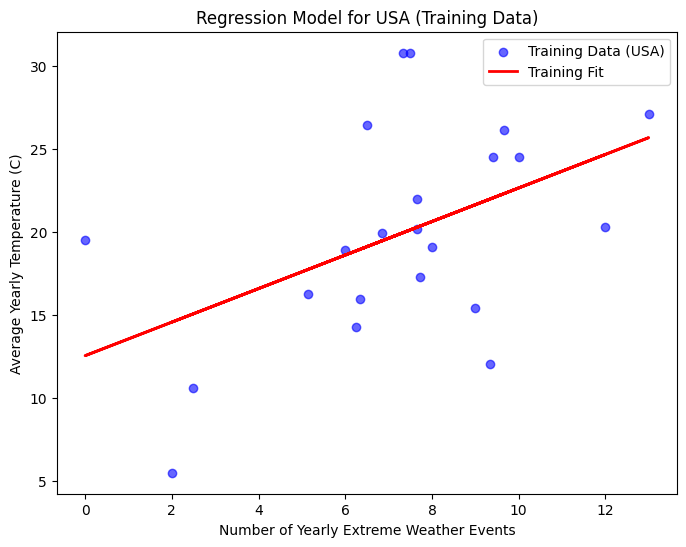

📊 Evaluation on USA:
- Mean Absolute Error (°C): 4.3481
- R² Score: 0.2290


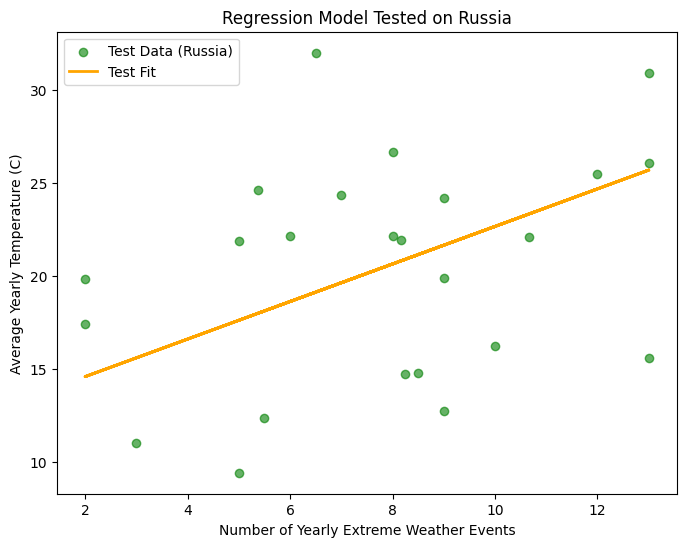

📊 Evaluation on Russia:
- Mean Absolute Error (°C): 4.8859
- R² Score: 0.0580


In [74]:
df_avg = df.groupby(["Year", "Country"], as_index=False).mean()

train_country = "USA"
test_country = "Russia"

train_data = df_avg[df_avg['Country'] == train_country]
test_data = df_avg[df_avg['Country'] == test_country]

# TRAINING

if train_data.empty or test_data.empty:
    print(f"No data available for training ({train_country}) or testing ({test_country}).")
else:

    X_train = train_data["Extreme Weather Events"].values.reshape(-1, 1)  
    Y_train = train_data["Avg Temperature (°C)"].values.reshape(-1, 1)  

    # generate linear coefficients on training data
    X_train_with_bias = tf.concat([tf.ones((X_train.shape[0], 1)), X_train], axis=1)
    beta_linear = linear_coefs(X_train_with_bias, Y_train)
    Y_train_pred = tf.matmul(X_train_with_bias, beta_linear)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_train, Y_train, label=f"Training Data ({train_country})", color="blue", alpha=0.6)
    plt.plot(X_train, Y_train_pred, label="Training Fit", color="red", linewidth=2)

    plt.ylabel("Average Yearly Temperature (C)")
    plt.xlabel("Number of Yearly Extreme Weather Events")
    plt.title(f"Regression Model for {train_country} (Training Data)")
    plt.legend()

    plt.show()
    mae = mean_absolute_error(Y_train, Y_train_pred.numpy())
    r2 = r2_score(Y_train, Y_train_pred.numpy())

    print(f"📊 Evaluation on {train_country}:")
    print(f"- Mean Absolute Error (°C): {mae:.4f}")
    print(f"- R² Score: {r2:.4f}")
    

# TESTING

    X_test = test_data["Extreme Weather Events"].values.reshape(-1, 1)  
    Y_test = test_data["Avg Temperature (°C)"].values.reshape(-1, 1)  

    # compute predictions on test data
    X_test_with_bias = tf.concat([tf.ones((X_test.shape[0], 1)), X_test], axis=1)
    Y_test_pred = tf.matmul(X_test_with_bias, beta_linear)
    
    # plot for test data
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test, Y_test, label=f"Test Data ({test_country})", color="green", alpha=0.6)
    plt.plot(X_test, Y_test_pred, label="Test Fit", color="orange", linewidth=2)

    plt.ylabel("Average Yearly Temperature (C)")
    plt.xlabel("Number of Yearly Extreme Weather Events")
    plt.title(f"Regression Model Tested on {test_country}")
    plt.legend()

    plt.show()

    mae = mean_absolute_error(Y_test, Y_test_pred.numpy())
    r2 = r2_score(Y_test, Y_test_pred.numpy())

    print(f"📊 Evaluation on {test_country}:")
    print(f"- Mean Absolute Error (°C): {mae:.4f}")
    print(f"- R² Score: {r2:.4f}")

# Polynomial Regression - 1 Country

In [71]:
def polynomial_features(X, degree):
    poly = [X**i for i in range(1, degree + 1)]
    return tf.concat([tf.ones((X.shape[0], 1))] + poly, axis=1)

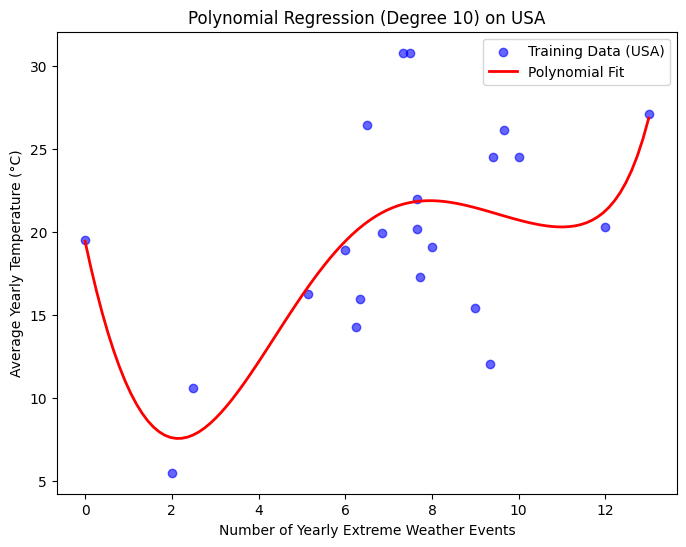

📈 Training Accuracy for USA (Degree 10):
- Mean Absolute Error (°C): 3.6017
- R² Score: 0.4543


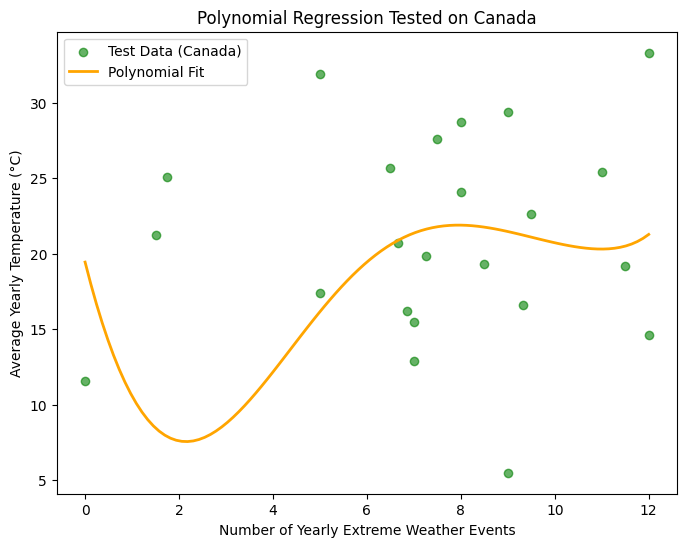

📈 Testing Accuracy for Canada (Degree 10):
- Mean Absolute Error (°C): 3.6017
- R² Score: 0.4543


In [72]:
degree = 10

# Average per (Year, Country)
df_avg = df.groupby(["Year", "Country"], as_index=False).mean()

train_country = "USA"
test_country = "Canada"

train_data = df_avg[df_avg['Country'] == train_country]
test_data = df_avg[df_avg['Country'] == test_country]

#TRAINING 
X_train = train_data["Extreme Weather Events"].values.reshape(-1, 1)
Y_train = train_data["Avg Temperature (°C)"].values.reshape(-1, 1)
X_poly_train = polynomial_features(tf.constant(X_train, dtype=tf.float32), degree)
Y_train_tensor = tf.constant(Y_train, dtype=tf.float32)

beta_poly = linear_coefs(X_poly_train, Y_train_tensor)
Y_train_pred = tf.matmul(X_poly_train, beta_poly)

x_curve = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
x_curve_poly = polynomial_features(tf.constant(x_curve, dtype=tf.float32), degree)
y_curve_pred = tf.matmul(x_curve_poly, beta_poly)

plt.figure(figsize=(8, 6))
plt.scatter(X_train, Y_train, label=f"Training Data ({train_country})", color="blue", alpha=0.6)
plt.plot(x_curve, y_curve_pred.numpy(), label="Polynomial Fit", color="red", linewidth=2)

plt.ylabel("Average Yearly Temperature (°C)")
plt.xlabel("Number of Yearly Extreme Weather Events")
plt.title(f"Polynomial Regression (Degree {degree}) on {train_country}")
plt.legend()
plt.show()

Y_train_pred_np = Y_train_pred.numpy()
Y_train_actual = Y_train_tensor.numpy()
mae_train = mean_absolute_error(Y_train_actual, Y_train_pred_np)
r2_train = r2_score(Y_train_actual, Y_train_pred_np)
print(f"📈 Training Accuracy for {train_country} (Degree {degree}):")
print(f"- Mean Absolute Error (°C): {mae_train:.4f}")
print(f"- R² Score: {r2_train:.4f}")

# TESTING
X_test = test_data["Extreme Weather Events"].values.reshape(-1, 1)
Y_test = test_data["Avg Temperature (°C)"].values.reshape(-1, 1)

X_poly_test = polynomial_features(tf.constant(X_test, dtype=tf.float32), degree)
Y_test_tensor = tf.constant(Y_test, dtype=tf.float32)
Y_test_pred = tf.matmul(X_poly_test, beta_poly)


x_curve = np.linspace(X_test.min(), X_test.max(), 100).reshape(-1, 1)
x_curve_poly = polynomial_features(tf.constant(x_curve, dtype=tf.float32), degree)
y_curve_pred = tf.matmul(x_curve_poly, beta_poly)

plt.figure(figsize=(8, 6))
plt.scatter(X_test, Y_test, label=f"Test Data ({test_country})", color="green", alpha=0.6)
plt.plot(x_curve, y_curve_pred.numpy(), label="Polynomial Fit", color="orange", linewidth=2)
plt.ylabel("Average Yearly Temperature (°C)")
plt.xlabel("Number of Yearly Extreme Weather Events")
plt.title(f"Polynomial Regression Tested on {test_country}")
plt.legend()
plt.show()
# Accuracy metrics
mae_test = mean_absolute_error(Y_train_actual, Y_train_pred_np)
r2_test = r2_score(Y_train_actual, Y_train_pred_np)
print(f"📈 Testing Accuracy for {test_country} (Degree {degree}):")
print(f"- Mean Absolute Error (°C): {mae_test:.4f}")
print(f"- R² Score: {r2_test:.4f}")


# Linear Regression - 5 Countries
#### Averaged temperature for datapoints with the same # of extreme weather events

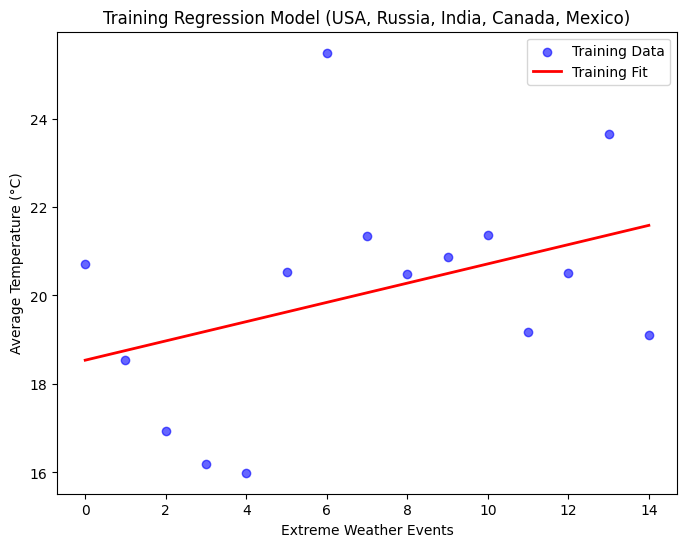

📊 Evaluation on USA:
- Mean Absolute Error (°C): 1.8054
- R² Score: 0.1432


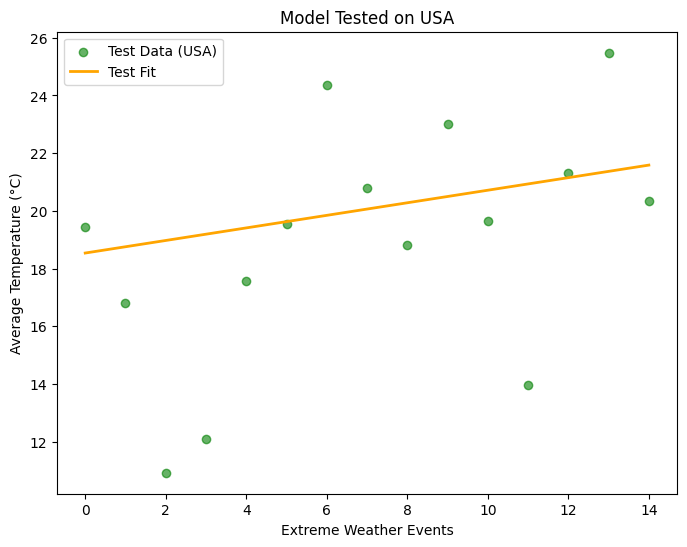

📊 Test Evaluation on USA:
- Mean Absolute Error (°C): 2.8468
- R² Score: 0.0921


In [76]:
train_countries = ["USA", "Russia", "India", "Canada", "Mexico"]
test_country = "USA"

train_data = df[df['Country'].isin(train_countries)]
test_data = df[df['Country'] == test_country]

train_grouped = train_data.groupby("Extreme Weather Events", as_index=False)["Avg Temperature (°C)"].mean()
test_grouped = test_data.groupby("Extreme Weather Events", as_index=False)["Avg Temperature (°C)"].mean()

# TRAINING
X_train = train_grouped["Extreme Weather Events"].values.reshape(-1, 1)
Y_train = train_grouped["Avg Temperature (°C)"].values.reshape(-1, 1)

X_train_with_bias = tf.concat([tf.ones((X_train.shape[0], 1)), X_train], axis=1)
beta_linear = linear_coefs(X_train_with_bias, Y_train)
Y_train_pred = tf.matmul(X_train_with_bias, beta_linear)

plt.figure(figsize=(8, 6))
plt.scatter(X_train, Y_train, label="Training Data", color="blue", alpha=0.6)
plt.plot(X_train, Y_train_pred, label="Training Fit", color="red", linewidth=2)
plt.xlabel("Extreme Weather Events")
plt.ylabel("Average Temperature (°C)")
plt.title(f"Training Regression Model ({', '.join(train_countries)})")
plt.legend()
plt.show()

# Evaluation metrics
mae_train = mean_absolute_error(Y_train, Y_train_pred.numpy())
r2_train= r2_score(Y_train, Y_train_pred.numpy())
print(f"📊 Evaluation on {train_country}:")
print(f"- Mean Absolute Error (°C): {mae_train:.4f}")
print(f"- R² Score: {r2_train:.4f}")

# TESTING
X_test = test_grouped["Extreme Weather Events"].values.reshape(-1, 1)
Y_test = test_grouped["Avg Temperature (°C)"].values.reshape(-1, 1)

X_test_with_bias = tf.concat([tf.ones((X_test.shape[0], 1)), X_test], axis=1)
Y_test_pred = tf.matmul(X_test_with_bias, beta_linear)

plt.figure(figsize=(8, 6))
plt.scatter(X_test, Y_test, label=f"Test Data ({test_country})", color="green", alpha=0.6)
plt.plot(X_test, Y_test_pred, label="Test Fit", color="orange", linewidth=2)
plt.xlabel("Extreme Weather Events")
plt.ylabel("Average Temperature (°C)")
plt.title(f"Model Tested on {test_country}")
plt.legend()
plt.show()

# Evaluation metrics
mae_test = mean_absolute_error(Y_test, Y_test_pred.numpy())
r2_test = r2_score(Y_test, Y_test_pred.numpy())
print(f"📊 Test Evaluation on {test_country}:")
print(f"- Mean Absolute Error (°C): {mae_test:.4f}")
print(f"- R² Score: {r2_test:.4f}")

# Polynomial Regression - 5 Countries
#### Averaged temperature for datapoints with the same # of extreme weather events

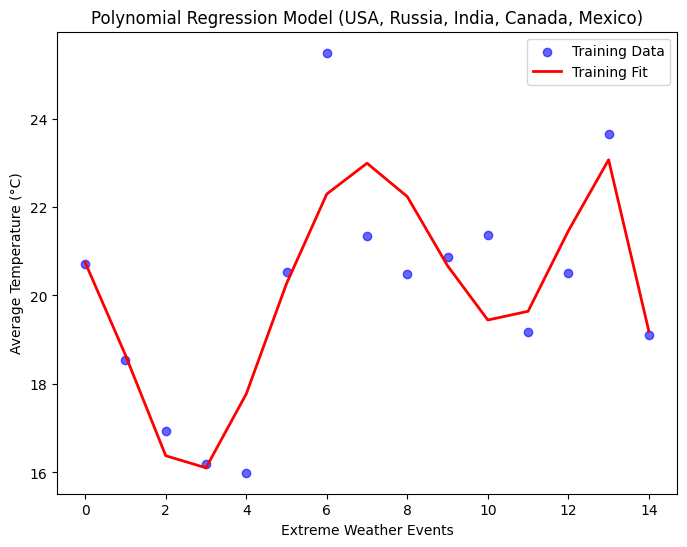

📊 Evaluation on USA, Russia, India, Canada, Mexico:
- Mean Absolute Error (°C): 0.9112
- R² Score: 0.7329


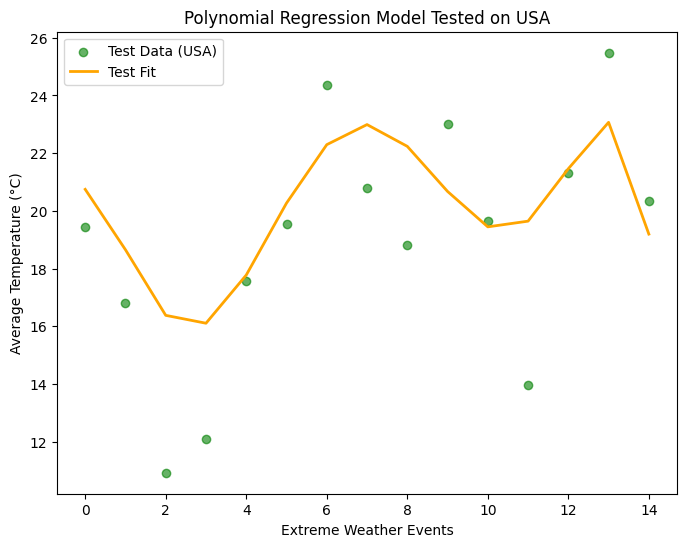

📊 Test Evaluation on USA:
- Mean Absolute Error (°C): 2.2104
- R² Score: 0.5181


In [80]:
def polynomial_features(X, degree):
    # Generate powers of X up to the specified degree
    return np.hstack([X**i for i in range(1, degree + 1)])

degree = 6

# TRAINING
X_train = train_grouped["Extreme Weather Events"].values.reshape(-1, 1)
Y_train = train_grouped["Avg Temperature (°C)"].values.reshape(-1, 1)

X_train_poly = polynomial_features(X_train, degree)
X_train_with_bias = np.hstack([np.ones((X_train_poly.shape[0], 1)), X_train_poly])
beta_poly = np.linalg.pinv(X_train_with_bias.T @ X_train_with_bias) @ X_train_with_bias.T @ Y_train
Y_train_pred = X_train_with_bias @ beta_poly

plt.figure(figsize=(8, 6))
plt.scatter(X_train, Y_train, label="Training Data", color="blue", alpha=0.6)
plt.plot(X_train, Y_train_pred, label="Training Fit", color="red", linewidth=2)
plt.xlabel("Extreme Weather Events")
plt.ylabel("Average Temperature (°C)")
plt.title(f"Polynomial Regression Model ({', '.join(train_countries)})")
plt.legend()
plt.show()

mae_train = mean_absolute_error(Y_train, Y_train_pred)
r2_train = r2_score(Y_train, Y_train_pred)
print(f"📊 Evaluation on {', '.join(train_countries)}:")
print(f"- Mean Absolute Error (°C): {mae_train:.4f}")
print(f"- R² Score: {r2_train:.4f}")

# TESTING
X_test = test_grouped["Extreme Weather Events"].values.reshape(-1, 1)
Y_test = test_grouped["Avg Temperature (°C)"].values.reshape(-1, 1)

X_test_poly = polynomial_features(X_test, degree)
X_test_with_bias = np.hstack([np.ones((X_test_poly.shape[0], 1)), X_test_poly])
Y_test_pred = X_test_with_bias @ beta_poly

plt.figure(figsize=(8, 6))
plt.scatter(X_test, Y_test, label=f"Test Data ({test_country})", color="green", alpha=0.6)
plt.plot(X_test, Y_test_pred, label="Test Fit", color="orange", linewidth=2)
plt.xlabel("Extreme Weather Events")
plt.ylabel("Average Temperature (°C)")
plt.title(f"Polynomial Regression Model Tested on {test_country}")
plt.legend()
plt.show()

mae_test = mean_absolute_error(Y_test, Y_test_pred)
r2_test = r2_score(Y_test, Y_test_pred)
print(f"📊 Test Evaluation on {test_country}:")
print(f"- Mean Absolute Error (°C): {mae_test:.4f}")
print(f"- R² Score: {r2_test:.4f}")